In [486]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

In [487]:
class LiveDeathClassifier(nn.Module):
    def __init__(self, num_features=19, h1=30, h2=30, h3=20, features=2) -> None:
        super(LiveDeathClassifier, self).__init__()
        self.fc1 = nn.Linear(num_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

In [488]:
main = pd.read_csv('../data/cleaned_train.csv')
main['Class'] = main['Class'].map(lambda x : 1 if x == 'DIE' else 0)
main

,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,HISTOLOGY,AGE,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,Class,OneHotSex
0,1,0,1,1,0,0,1,0,1,1,1,0,0.661290,0.584416,0.411504,0.541667,0.18750,0.31,1,1.0
1,0,0,1,0,0,0,1,1,1,0,1,0,0.709677,0.090909,0.333702,0.022727,0.28125,0.63,0,1.0
2,1,0,1,0,0,0,1,0,0,0,0,1,0.532258,0.038961,0.141593,0.575758,0.59375,0.63,0,1.0
3,0,0,1,0,0,1,1,1,1,1,1,0,0.290323,0.129870,0.668142,0.632576,0.75000,0.57,0,1.0
4,1,0,1,0,0,1,1,0,1,0,0,1,0.435484,0.090909,0.185841,0.121212,0.71875,0.57,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0,0,1,1,1,0,0,1,0,0,0,1,0.258065,0.129870,0.725664,0.515152,0.62500,0.90,0,1.0
98,1,0,0,0,0,0,1,0,0,0,0,0,0.500000,0.012987,0.942478,0.132576,0.53125,0.90,1,1.0
99,1,0,0,0,0,0,0,1,0,0,0,1,0.467742,0.064935,0.243363,0.113636,0.65625,0.85,0,1.0
100,1,1,1,1,0,0,0,0,0,0,0,1,0.403226,0.090909,0.110619,0.117424,0.62500,0.56,0,1.0


In [489]:
X = main.copy()

for col in ['Class']:
    if col in main.columns:
        X = X.drop(col, axis=1)

y=main[['Class']]

In [490]:
from imblearn.over_sampling import RandomOverSampler

# resample the X_train and y_train data
ros = RandomOverSampler(random_state=69)

# for now, ros is only applied on the train data
X, y = ros.fit_resample(X, y)

X.shape, y.shape

((162, 19), (162, 1))

In [491]:
X = X.values
y = y.values

In [492]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=69, shuffle=True)

In [493]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [494]:
y_train = torch.LongTensor(y_train).squeeze()
y_test = torch.LongTensor(y_test).squeeze()

In [495]:
y_test.shape

torch.Size([33])

In [496]:
X_train.shape

torch.Size([129, 19])

In [497]:
epochs = 100
losses, eval_losses = [], []

model = LiveDeathClassifier()
criterion = nn.CrossEntropyLoss()
optimzer = torch.optim.Adam(model.parameters(), lr=0.01)

for i in range(epochs):
    model.train()
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy())
    optimzer.zero_grad()
    loss.backward()
    optimzer.step()
    
    with torch.no_grad():
        model.eval()
        y_eval = model.forward(X_test)
        loss_eval = criterion(y_eval, y_test)
        eval_losses.append(loss_eval.detach().numpy())
    
    print(f"Epoch : {i+1} and loss {loss} and eval {loss_eval}")



Epoch : 1 and loss 0.7003408074378967 and eval 0.6893889307975769
Epoch : 2 and loss 0.6906787157058716 and eval 0.6870212554931641
Epoch : 3 and loss 0.6856226921081543 and eval 0.682398796081543
Epoch : 4 and loss 0.6788942217826843 and eval 0.6727117896080017
Epoch : 5 and loss 0.6665690541267395 and eval 0.6553367376327515
Epoch : 6 and loss 0.6477938294410706 and eval 0.6301906108856201
Epoch : 7 and loss 0.623587429523468 and eval 0.5979490876197815
Epoch : 8 and loss 0.5936983823776245 and eval 0.5583664178848267
Epoch : 9 and loss 0.5571551322937012 and eval 0.5112012028694153
Epoch : 10 and loss 0.5142838358879089 and eval 0.4604076147079468
Epoch : 11 and loss 0.46851393580436707 and eval 0.41152581572532654
Epoch : 12 and loss 0.42610207200050354 and eval 0.3703981637954712
Epoch : 13 and loss 0.3939666450023651 and eval 0.3398159146308899
Epoch : 14 and loss 0.3760432004928589 and eval 0.31618377566337585
Epoch : 15 and loss 0.3687610328197479 and eval 0.3026737570762634
Ep

<Axes: >

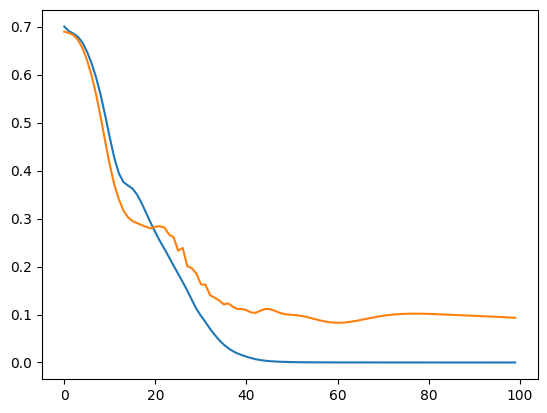

In [498]:
losses = [float(x) for x in losses]
losses_val = [float(x) for x in eval_losses]

sns.lineplot(losses)
sns.lineplot(losses_val)

In [499]:
with torch.no_grad():
    model.eval()
    for i, data in enumerate(X_test):
        y_pred = model.forward(data)

        print(f'{i+1} : {str(y_pred)}   {y_pred.argmax().item()}  {y_test[i]}')


1 : tensor([-2.4202,  0.5324])   1  0
2 : tensor([ 14.2899, -11.1999])   0  0
3 : tensor([-7.0050,  3.6028])   1  1
4 : tensor([-6.0018,  3.2843])   1  1
5 : tensor([ 16.1729, -12.6690])   0  0
6 : tensor([ 13.5912, -10.6906])   0  0
7 : tensor([ 14.8731, -11.7459])   0  0
8 : tensor([-7.1042,  3.6602])   1  1
9 : tensor([ 8.3381, -6.4675])   0  0
10 : tensor([10.8692, -9.0542])   0  0
11 : tensor([-10.6200,   5.6906])   1  1
12 : tensor([-8.9313,  4.8590])   1  1
13 : tensor([ 8.2770, -6.9074])   0  0
14 : tensor([-8.8645,  4.6670])   1  1
15 : tensor([-10.4178,   5.5583])   1  1
16 : tensor([ 0.8160, -1.8551])   0  0
17 : tensor([-10.4178,   5.5583])   1  1
18 : tensor([-6.0018,  3.2843])   1  1
19 : tensor([ 17.4127, -13.6872])   0  0
20 : tensor([ 7.8172, -6.5060])   0  0
21 : tensor([10.1019, -8.1289])   0  0
22 : tensor([-7.7100,  4.0951])   1  1
23 : tensor([ 3.1880, -3.1156])   0  0
24 : tensor([ 8.8275, -7.3746])   0  0
25 : tensor([-9.6524,  5.2037])   1  1
26 : tensor([11.09

In [500]:
test = pd.read_csv('../data/cleaned_test.csv')

In [501]:
test_tens = torch.LongTensor(test.values).squeeze().float()
test_tens

tensor([[0., 0., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 0., 0., 1.],
        [1., 1., 0.,  ..., 0., 0., 1.]])

In [502]:
list = []

with torch.no_grad():
    model.eval()
    for i, data in enumerate(test_tens):
        y_pred = model.forward(data)

        list.append(y_pred.argmax().item())

In [503]:
final = pd.DataFrame({"Class":list})
final

final['Class'] = final['Class'].apply(lambda x : 'DIE' if x == 1 else 'LIVE')
final.value_counts()

Class
LIVE     30
DIE      23
Name: count, dtype: int64

In [504]:
csv = pd.read_csv('../Alina/group_7.csv')
csv.shape

(53, 1)

In [505]:
final

,Class
0,LIVE
1,LIVE
2,DIE
3,DIE
4,LIVE
5,LIVE
6,LIVE
7,DIE
8,DIE
9,LIVE


In [506]:
final.to_csv('group_7-2.csv', index=False)